![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 3 - Optimization Methods </center>
### <center> Update Rules (SGDM & Adam)</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/03_OptimizationMethods/MainUpdateRules_Solution.ipynb)

In [1]:
#-- Wide screen:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib

np.random.seed(1)

For Colab users:

In [4]:
if 'google.colab' in str(get_ipython()):
    !wget https://raw.githubusercontent.com/FixelAlgorithmsTeam/FixelCourses/master/DeepLearningMethods/03_OptimizationMethods/UpdateRulesAux.py

In [5]:
#-- What we have so far:
from UpdateRulesAux import LinearLayer, ReLULayer, SequentialModel, CrossEntropyLoss, Dataset, Accuracy

### Get Fashion MNIST dataset

In [6]:
import torchvision
import torchvision.transforms as transforms

#-- For now, we use PyTorch just to get the data:
oTrainSet = torchvision.datasets.FashionMNIST(root='../../data', train=True,  download=True, transform=transforms.ToTensor())
oTestSet  = torchvision.datasets.FashionMNIST(root='../../data', train=False, download=True, transform=transforms.ToTensor())

lClasses = oTrainSet.classes
mTrainX  = oTrainSet.data.view(-1,784).numpy() / 255
mTestX   = oTestSet .data.view(-1,784).numpy() / 255
vTrainY  = oTrainSet.targets.numpy()
vTestY   = oTestSet .targets.numpy()

(
mTrainX.shape, 
vTrainY.shape, 
mTestX .shape,  
vTestY .shape
)

((60000, 784), (60000,), (10000, 784), (10000,))

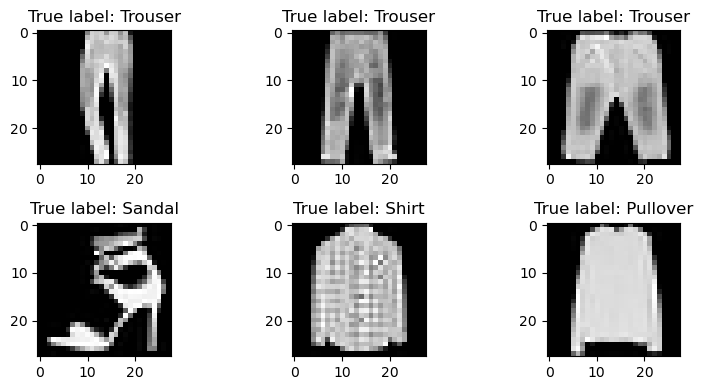

In [7]:
#-- Plot a few examples:
N, d   = mTrainX.shape
fig, _ = plt.subplots(2, 3, figsize=(8, 4))
for ax in fig.axes:
    idx = np.random.randint(N)
    ax.imshow   (np.reshape(mTrainX[idx,:], (28, 28)), cmap='gray')
    ax.set_title(f'True label: {lClasses[vTrainY[idx]]}')
    
plt.tight_layout()
plt.show()

####  Normalize data:

In [8]:
vMean = mTrainX.mean(0)
vStd  = mTrainX.std (0)

mTrainX -= vMean
mTestX  -= vMean
mTrainX /= vStd
mTestX  /= vStd

#### Data loaders:

In [9]:
batchSize = 256
oTrainSet = Dataset(mTrainX.T, vTrainY, batchSize)
oTestSet  = Dataset(mTestX.T,  vTestY,  batchSize)

### A basic optimizer (only SGD):
$$\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}-\mu\nabla_{\boldsymbol{p}}L$$

In [10]:
#-- Basic gradient descent update rule:
class SGD:
    def __init__(self, lr=1e-3):
        self.lr = lr
        
    def Step(self, mP, mDp, dState={}):
        mP -= self.lr * mDp
        return mP, dState

#--------------------------------------------------------------------------------#
#--------------------------------------------------------------------------------#
class Optimizer:
    def __init__(self, oUpdateRule):
        self.oUpdateRule = oUpdateRule #-- SGD, SGDM, ADAM
        self.dStates     = {}
            
    def Step(self, oModel, lr=None):
        if lr is not None:
            self.oUpdateRule.lr = lr
        
        for ii, oLayer in enumerate(oModel.lLayers):
            for sParamKey in oLayer.dGrads:
                #-- Get param, gradient and history:
                mP       = oLayer.dParams[sParamKey]
                mDp      = oLayer.dGrads [sParamKey]
                sParamID = f'{ii}_{sParamKey}'
                dState   = self.dStates.get(sParamID, {})
                
                #-- Apply step:
                mP, dState = self.oUpdateRule.Step(mP, mDp, dState)
                
                #-- Set param and hisoty:
                oLayer.dParams[sParamKey] = mP
                self.dStates  [sParamID ] = dState

### Epoch with an optimizer:
* We merge `TrainEpoch` and `ValidationEpoch` into a single function.  
* `bTrain` indicates whether we train or validate.

In [11]:
import time
    
def Epoch(oModel, oData, oOptim=None, bTrain=True):
    
    epochLoss = 0
    epochAcc  = 0
    count     = 0
    #-- Iterate over the mini-batches:
    for ii, (mX, vY) in enumerate(oData):
        
        Nb     = len(vY)
        count += Nb
        
        #-- Forward:
        mZ        = oModel.Forward(mX)
        loss, mDz = CrossEntropyLoss(vY, mZ)

        if bTrain == True:
            oModel.Backward(mDz) #-- backward
            oOptim.Step(oModel)  #-- update parameters
            
        epochLoss += Nb * loss
        epochAcc  += Nb * Accuracy(mZ, vY)
        print(f'\rIteration: {ii:3d}: loss = {loss:2.6f}', end='')
    
    print('', end='\r')
    epochLoss /= count
    epochAcc  /= count
    
    return epochLoss, epochAcc

In [12]:
def TrainModel(oModel, oTrainData, oValData, nEpochs, oOptim):

    vTrainLoss = np.full(nEpochs, np.nan)
    vTrainAcc  = np.full(nEpochs, np.nan)
    vValLoss   = np.full(nEpochs, np.nan)
    vValAcc    = np.full(nEpochs, np.nan)
    for epoch in range(nEpochs):
        startTime           = time.time()
        trainLoss, trainAcc = Epoch(oModel, oTrainData, oOptim, bTrain=True )
        valLoss,   valAcc   = Epoch(oModel, oValData,           bTrain=False)
        epochTime           = time.time() - startTime
        
        #-- Display:
        print('Epoch '              f'{epoch    :3d}:',  end='')
        print(' | Train loss: '     f'{trainLoss:6.3f}', end='')
        print(' | Val loss: '       f'{valLoss  :6.3f}', end='')
        print(' | Train Accuracy: ' f'{trainAcc :6.3f}', end='')
        print(' | Val Accuracy: '   f'{valAcc   :6.3f}', end='')
        print(' | epoch time: '     f'{epochTime:6.3f} |')
        
        vTrainLoss[epoch] = trainLoss
        vTrainAcc [epoch] = trainAcc
        vValLoss  [epoch] = valLoss
        vValAcc   [epoch] = valAcc
        
    return vTrainLoss, vTrainAcc, vValLoss, vValAcc

####  Define a model:

In [13]:
def GetModel():
    oModel = SequentialModel([
        LinearLayer(784, 350), ReLULayer(),
        LinearLayer(350, 250), ReLULayer(),
        LinearLayer(250, 150), ReLULayer(),
        LinearLayer(150, 50 ), ReLULayer(),
        LinearLayer(50,  10 ),
    ])
    
    return oModel

### Train the model with SGD:

In [14]:
oModel  = GetModel()
oOptim  = Optimizer(SGD(lr=2e-2))
nEpochs = 10

TrainModel(oModel, oTrainSet, oTestSet, nEpochs, oOptim);

Epoch   0: | Train loss:  0.687 | Val loss:  0.539 | Train Accuracy:  0.769 | Val Accuracy:  0.812 | epoch time:  1.891 |
Epoch   1: | Train loss:  0.436 | Val loss:  0.477 | Train Accuracy:  0.845 | Val Accuracy:  0.831 | epoch time:  1.921 |
Epoch   2: | Train loss:  0.385 | Val loss:  0.441 | Train Accuracy:  0.861 | Val Accuracy:  0.844 | epoch time:  1.913 |
Epoch   3: | Train loss:  0.355 | Val loss:  0.421 | Train Accuracy:  0.871 | Val Accuracy:  0.854 | epoch time:  1.893 |
Epoch   4: | Train loss:  0.331 | Val loss:  0.412 | Train Accuracy:  0.880 | Val Accuracy:  0.854 | epoch time:  1.879 |
Epoch   5: | Train loss:  0.314 | Val loss:  0.402 | Train Accuracy:  0.886 | Val Accuracy:  0.856 | epoch time:  1.855 |
Epoch   6: | Train loss:  0.299 | Val loss:  0.393 | Train Accuracy:  0.892 | Val Accuracy:  0.861 | epoch time:  1.863 |
Epoch   7: | Train loss:  0.285 | Val loss:  0.399 | Train Accuracy:  0.896 | Val Accuracy:  0.861 | epoch time:  1.894 |
Epoch   8: | Train loss:

### SGDM
$$\boldsymbol{v}^{\left(t\right)}=\beta\boldsymbol{v}^{\left(t-1\right)}-\mu\nabla f\left(\boldsymbol{p}^{\left(t\right)}\right)$$
$$\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}+\boldsymbol{v}^{\left(t\right)}$$

In [15]:
class SGDM:
    def __init__(self, lr=1e-3, beta=0.9):
        self.lr   = lr
        self.beta = beta
        
    def Step(self, mP, mDp, dState={}):
        mV            = dState.get('mV', np.zeros(mP.shape))
        mV            = self.beta * mV - self.lr * mDp
        mP           += mV
        dState['mV']  = mV
        
        return mP, dState

### Train the same architecture with SGDM:

In [16]:
oModel  = GetModel()
oOptim  = Optimizer(SGDM(lr=1e-2, beta=0.9))
nEpochs = 10

TrainModel(oModel, oTrainSet, oTestSet, nEpochs, oOptim);

Epoch   0: | Train loss:  0.559 | Val loss:  0.438 | Train Accuracy:  0.803 | Val Accuracy:  0.841 | epoch time:  2.222 |
Epoch   1: | Train loss:  0.351 | Val loss:  0.374 | Train Accuracy:  0.872 | Val Accuracy:  0.867 | epoch time:  2.181 |
Epoch   2: | Train loss:  0.303 | Val loss:  0.378 | Train Accuracy:  0.889 | Val Accuracy:  0.865 | epoch time:  2.380 |
Epoch   3: | Train loss:  0.273 | Val loss:  0.366 | Train Accuracy:  0.900 | Val Accuracy:  0.866 | epoch time:  2.226 |
Epoch   4: | Train loss:  0.249 | Val loss:  0.358 | Train Accuracy:  0.908 | Val Accuracy:  0.873 | epoch time:  2.338 |
Epoch   5: | Train loss:  0.226 | Val loss:  0.342 | Train Accuracy:  0.917 | Val Accuracy:  0.882 | epoch time:  2.345 |
Epoch   6: | Train loss:  0.205 | Val loss:  0.357 | Train Accuracy:  0.926 | Val Accuracy:  0.880 | epoch time:  2.312 |
Epoch   7: | Train loss:  0.187 | Val loss:  0.352 | Train Accuracy:  0.932 | Val Accuracy:  0.881 | epoch time:  2.357 |
Epoch   8: | Train loss:

#### Question:
Which optimizer obtains a better performance after 10 iterations?

### Exercise
* Implement the `Adam` update rule
* Train your model with `Adam` (for 10 epochs).  
You should get a better training loss (and also a better validation loss)

#### Adam:
(start with $t=1$)
1. $\boldsymbol{g}=\nabla f\left(\boldsymbol{p}^{\left(t\right)}\right)$
2. $\boldsymbol{v}^{\left(t\right)}=\beta_{1}\boldsymbol{v}^{\left(t-1\right)}+\left(1-\beta_{1}\right)\boldsymbol{g}$
3. $\boldsymbol{s}^{\left(t\right)}=\beta_{2}\boldsymbol{s}^{\left(t-1\right)}+\left(1-\beta_{2}\right)\left(\boldsymbol{g}\odot\boldsymbol{g}\right)$
4. $\tilde{\boldsymbol{v}}^{\left(t\right)}=\frac{1}{\left(1-\beta_{1}^{t}\right)}\boldsymbol{v}^{\left(t\right)}$
5. $\tilde{\boldsymbol{s}}^{\left(t\right)}=\frac{1}{\left(1-\beta_{2}^{t}\right)}\boldsymbol{s}^{\left(t\right)}$
6. $\boldsymbol{p}^{\left(t+1\right)}=\boldsymbol{p}^{\left(t\right)}-\mu\tilde{\boldsymbol{v}}^{\left(t\right)}\oslash\left(\sqrt{\tilde{\boldsymbol{s}}^{\left(t\right)}}+\epsilon\right)$

In [17]:
class Adam:
    def __init__(self, lr=1e-3, β1=0.9, β2=0.99, ϵ=1e-8):
        self.lr = lr
        self.β1 = β1
        self.β2 = β2
        self.ϵ  = ϵ
        
    def Step(self, mP, mDp, dState={}):
        mV            = dState.get('mV', np.zeros(mP.shape))
        mS            = dState.get('mS', np.zeros(mP.shape))
        ii            = dState.get('ii', 0) + 1
        
        mV            = self.β1 * mV + (1 - self.β1) * mDp
        mS            = self.β2 * mS + (1 - self.β2) * mDp * mDp
        
        mTildeV       = mV / (1 - self.β1**ii)
        mTildeS       = mS / (1 - self.β2**ii)
        
        mP           -= self.lr * mTildeV / (np.sqrt(mTildeS) + self.ϵ)
        dState['mV']  = mV
        dState['mS']  = mS
        dState['ii']  = ii
        
        return mP, dState

In [18]:
oModel  = GetModel()
oOptim  = Optimizer(Adam(lr=5e-4, β1=0.9, β2=0.9))
nEpochs = 10

TrainModel(oModel, oTrainSet, oTestSet, nEpochs, oOptim);

Epoch   0: | Train loss:  0.500 | Val loss:  0.397 | Train Accuracy:  0.824 | Val Accuracy:  0.856 | epoch time:  3.931 |
Epoch   1: | Train loss:  0.325 | Val loss:  0.363 | Train Accuracy:  0.882 | Val Accuracy:  0.872 | epoch time:  3.969 |
Epoch   2: | Train loss:  0.278 | Val loss:  0.348 | Train Accuracy:  0.898 | Val Accuracy:  0.875 | epoch time:  3.832 |
Epoch   3: | Train loss:  0.242 | Val loss:  0.345 | Train Accuracy:  0.910 | Val Accuracy:  0.880 | epoch time:  3.861 |
Epoch   4: | Train loss:  0.216 | Val loss:  0.342 | Train Accuracy:  0.920 | Val Accuracy:  0.882 | epoch time:  3.835 |
Epoch   5: | Train loss:  0.191 | Val loss:  0.335 | Train Accuracy:  0.929 | Val Accuracy:  0.888 | epoch time:  3.782 |
Epoch   6: | Train loss:  0.172 | Val loss:  0.349 | Train Accuracy:  0.937 | Val Accuracy:  0.888 | epoch time:  3.774 |
Epoch   7: | Train loss:  0.154 | Val loss:  0.361 | Train Accuracy:  0.943 | Val Accuracy:  0.884 | epoch time:  3.916 |
Epoch   8: | Train loss:

#### Extra
* Train your model for $30-40$ epochs.
* Plot the train\validation loss\accuracy as a function of the epochs.
* Answer the question:   
Does training for many epochs is always the right thing to do?

In [19]:
oModel  = GetModel()
oOptim  = Optimizer(Adam(lr=5e-4, β1=0.9, β2=0.9))
nEpochs = 40

vTrainLoss, vTrainAcc, vValLoss, vValAcc = TrainModel(oModel, oTrainSet, oTestSet, nEpochs, oOptim)

Epoch   0: | Train loss:  0.481 | Val loss:  0.398 | Train Accuracy:  0.829 | Val Accuracy:  0.859 | epoch time:  3.697 |
Epoch   1: | Train loss:  0.317 | Val loss:  0.393 | Train Accuracy:  0.885 | Val Accuracy:  0.863 | epoch time:  3.800 |
Epoch   2: | Train loss:  0.274 | Val loss:  0.346 | Train Accuracy:  0.900 | Val Accuracy:  0.878 | epoch time:  3.712 |
Epoch   3: | Train loss:  0.239 | Val loss:  0.348 | Train Accuracy:  0.912 | Val Accuracy:  0.882 | epoch time:  3.682 |
Epoch   4: | Train loss:  0.210 | Val loss:  0.338 | Train Accuracy:  0.922 | Val Accuracy:  0.883 | epoch time:  3.743 |
Epoch   5: | Train loss:  0.187 | Val loss:  0.340 | Train Accuracy:  0.931 | Val Accuracy:  0.886 | epoch time:  4.011 |
Epoch   6: | Train loss:  0.168 | Val loss:  0.356 | Train Accuracy:  0.937 | Val Accuracy:  0.885 | epoch time:  3.907 |
Epoch   7: | Train loss:  0.152 | Val loss:  0.363 | Train Accuracy:  0.943 | Val Accuracy:  0.886 | epoch time:  3.881 |
Epoch   8: | Train loss:

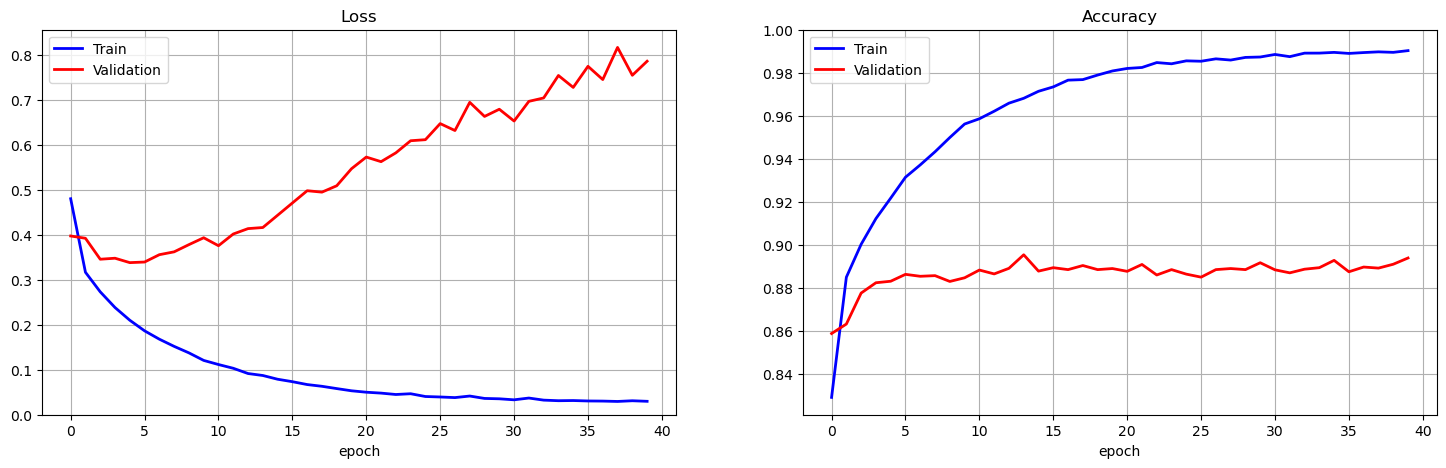

In [23]:
plt.figure(figsize=(18, 5))

plt.subplot(1,2,1)
plt.plot   (vTrainLoss, 'b', lw=2, label='Train'     )
plt.plot   (vValLoss,   'r', lw=2, label='Validation')
plt.title  ('Loss')
plt.xlabel ('epoch')
plt.ylim   (bottom=0)
plt.legend ()
plt.grid   ()

plt.subplot(1,2,2)
plt.plot   (vTrainAcc, 'b', lw=2, label='Train'     )
plt.plot   (vValAcc,   'r', lw=2, label='Validation')
plt.title  ('Accuracy')
plt.xlabel ('epoch')
plt.ylim   (top=1)
plt.legend ()
plt.grid   ()
plt.show   ()